<h1> A guide to Mumbai's restaurants

<h2> Contents of this notebook </h2>

- Introduction <br>
- Collection of data <br>
- Data Cleaning <br>
- Methodology <br>
- Analysis <br>
- Results and Discussion <br>
- Conclusion <br>

<h3> -> Introduction </h3>
This Capstone project has been created keeping in mind the best available restaurant options available in the city of Mumbai, which happens to be the financial, commercial and entertainment capital of India.

It deals with the APIs provided by Foursquare and Zomato, which is a popular food delivery application serving a total of 24 countries. The main criteria to segregate the restaurants is the average price at the venue and its ratings on the latter provided by the users.

<h3>-> Collection of Data </h3>
The two APIs used to collect data are: <br>
- <b>Foursquare API:</b> The Foursquare API will fetch us the venues in Mumbai in a radius of 40 kilometers from the co-ordinate location of the city. <br>
- <b>Zomato API:</b> The location, average price and user ratings are provided by the Zomato API. <br>

<h3> The city of Mumbai </h3>
Mumbai is one of the most densely populated cities in the country with the second-largest population in the world. It is the financial, commercial and entertainment capital of India, as it brings stakeholders from around the world and competes with the most sought-after cities in the world. <br>

The population of Mumbai was recorded to be close to 24 million in October 2019 and the restaurants are obviously a big feature for the people coming in from far away.

Let's move forward to the most important part of this project, the code!

In [5]:
MUM_LATITUDE = 19.0760
MUM_LONGITUDE = 72.8777
print('The geograpical coordinates of Mumbai are {}, {}.'.format(MUM_LATITUDE, MUM_LONGITUDE))

The geograpical coordinates of Mumbai are 19.076, 72.8777.


Let's have a look at the zoomed view of the map of Mumbai. the marker is placed at the co-ordinates mentioned above.

In [6]:
import folium

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)
folium.Marker([MUM_LATITUDE, MUM_LONGITUDE]).add_to(mumbai_map)
mumbai_map.save("mumbai.html")
mumbai_map

<b>Using the Foursquare API</b>

In [7]:
FOURSQUARE_CLIENT_ID = '14C3ANUSAVHCAAGTKA2VWDKFI3SURWJRQZGRVHUQQNGEQHKE'
FOURSQUARE_CLIENT_SECRET = 'LFJ1WFPY0KJGNKT5VORFSVKQU0B4SPXMKZN43ELV4SR4XEV1'
RADIUS = 4000
NO_OF_VENUES = 100
VERSION = '20200520' # Current date

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

I will be calling the API repeatedly until I get all venues from the API in the aforementioned radius. This API can fetch a maximum of 100 venues each time, so I'll be fetching all venues by iteratively calling it and increasing the offset every time.

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

In [10]:
pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        MUM_LATITUDE, 
                                                                        MUM_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 83 venues fetched within a total radius of 4.0 Km

Total 183 venues fetched


<b> Using the Zomato API </b>

In [11]:
headers = {'user-key': '9e5eef0295f8585b04290428b2faa0a3'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

<h3> -> Data Cleaning </h3>
This part of the analysis is very important as the alignment of the data has to be taken care of and see that the locations match perfectly with the help of latitudes and longitudes. <br> <br>

Going ahead by plotting the Foursquare data on the map of Mumbai.

In [13]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  

mumbai_map.save("Mumbai Venues by Foursquare.html")
mumbai_map

Plotting the Zomato data on the map

In [14]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [15]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [16]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Sofitel Mumbai BKC,Hotel,19.0674,72.8690,Tuskers - Sofitel,19.0673,72.8692,3300.0,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",-0.0001,0.0002
1,Trident,Hotel,19.0668,72.8675,O22 - Trident,19.0672,72.8675,4000.0,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",0.0004,0.0000
2,Masala Library,Indian Restaurant,19.0689,72.8697,Masala Library,19.0690,72.8696,5000.0,4.0,4.4,"Ground Floor, First International Financial Ce...",0.0001,-0.0001
3,Natural's Ice Cream,Ice Cream Shop,19.0776,72.8630,Natural Ice Cream,19.0776,72.8628,300.0,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",0.0000,-0.0002
4,Smoke House Deli (BKC),Deli / Bodega,19.0688,72.8697,Smoke House Deli,19.0688,72.8695,2500.0,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",0.0000,-0.0002
5,Yauatcha,Dim Sum Restaurant,19.0614,72.8627,Yauatcha,19.0611,72.8626,2800.0,4.0,4.5,"Raheja Towers, Bandra Kurla Complex, Mumbai",-0.0003,-0.0001
6,Delhi Zaika,Indian Restaurant,19.0771,72.8783,Delhi Zaika,19.0770,72.8784,700.0,2.0,3.8,"5/6, Near Kamran Kalpana Theater, LBS Marg, Ku...",-0.0001,0.0001
7,Theobrama,Dessert Shop,19.0635,72.8617,Theobroma,19.0637,72.8621,900.0,2.0,4.2,"The Capital, Ground Floor, Bandra Kurla Comple...",0.0002,0.0004
8,Starbucks,Coffee Shop,19.0866,72.8898,Starbucks Coffee,19.0865,72.8898,700.0,2.0,4.1,"First Floor, Phoenix Market City, LBS Marg, Ku...",-0.0001,0.0000
9,SodaBottleOpenerWala,Irani Cafe,19.0636,72.8624,SodaBottleOpenerWala,19.0638,72.8620,1500.0,3.0,4.1,"Ground Floor, The Capital Building, G Block, B...",0.0002,-0.0004


In some rows, same locations co-incide with two different venues and hence had to be dropped from the data in order to clear the confusion and get clear visual data. Hence, we drop some of those that were too close. For example, 'Maya and Mojo Pizza' and '212 All Day and Shizusan'

In [17]:
selected_venues = selected_venues.drop([14, 17, 18, 19, 25, 26, 27, 29, 33, 41, 44, 48, 49, 65, 70, 80, 81]).reset_index(drop = True)

In [18]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's have a look at what is left in the dataset

In [21]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0
1,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0
2,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.4,"Ground Floor, First International Financial Ce...",2500.0
3,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0
4,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",1250.0


In [22]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 60


<h3> -> Methodology </h3>
'A guide to Mumbai's restaurants' aims at identifying the restaurants in Mumbai based on their user ratings and average costs. 

I first retrieved the necessary data from two popular APIs namely Foursquare and Zomato. Restaurants' information can be extracted from these APIs and can be put to use. The latitude and longitude values can fetch the venue rating and price information.

Then the explored data is retrieved from the two APIs and plotted on the map and the top category types are identified. The data from the two sources is precisely combined based on the name and 'latitude and longitude' values. The final dataset includes the rating and price values for each venue.

Next, I'll analyse the data that has been created on the basis of average price and user ratings of each restaurant. Then I'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which restaurants can be recommended to the interested audience.

The discussions and conclusions will be seen at the end of this project.

<h3> -> Analysis </h3>
The two sections used rating the restaurants will be the rating and price. The rating is the user rating given on the Zomato application and the price factor will be the average price and price per person that is usually generated at the restaurant.<br><br>
The restaurants will be rated from 1 to 5 for ranking them.

<BarContainer object of 26 artists>

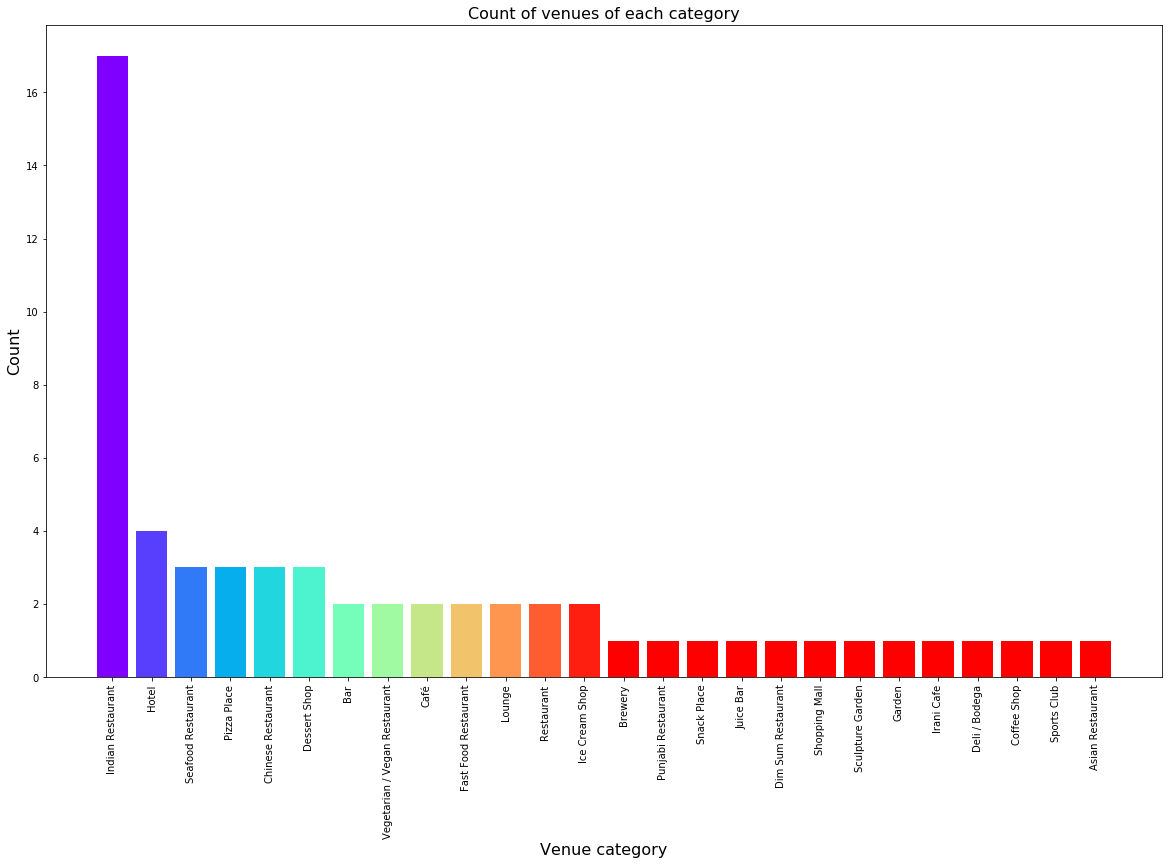

In [28]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 2, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

The above graph tells the user that Mumbai has good quality of 'Indian Restaurants' and if one likes Indian food, he/she will surely have a good time!

<h3>Rating </h3>
The rating of the restaurants is decided by the users and then entered on the application. Here, we take into consideration the number of restaurants and their average rating and count the number of restaurants with rating from 1-5.

Text(0.5, 1.0, 'Count of venues with given rating')

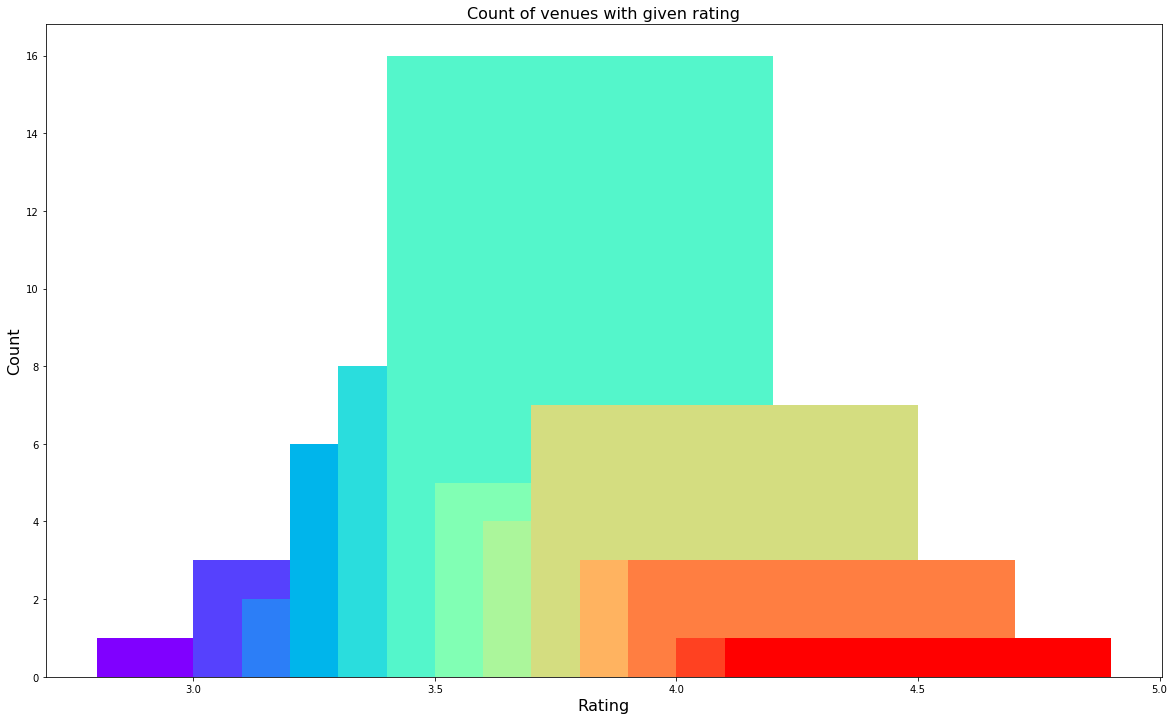

In [29]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that maximum restaurants have their rating close to 3.4.<br><br>
Let's create some bins!

In [30]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Not good', 'Okay', 'Good', 'Excellent']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Plotting them on the map

In [31]:
color_map = {'Not good': 'pink', 'Okay': 'blue', 'Good': 'purple', 'Excellent': 'green'}

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(mumbai_map)  

mumbai_map.save("Mumbai Venues Ratings.html")
mumbai_map

It is evident from the map that a lot of 'Good' rated venues are situated near Chembur and Ghatkopar. These are the places to explore, new guys!

<h3>Price </h3>
For the classification based on price, two factors will be considered: <br>
- Average price per person <br>
- Price Range<br><br>
Looking at the Average price first,

Text(0.5, 1.0, 'Count of venues with given average price')

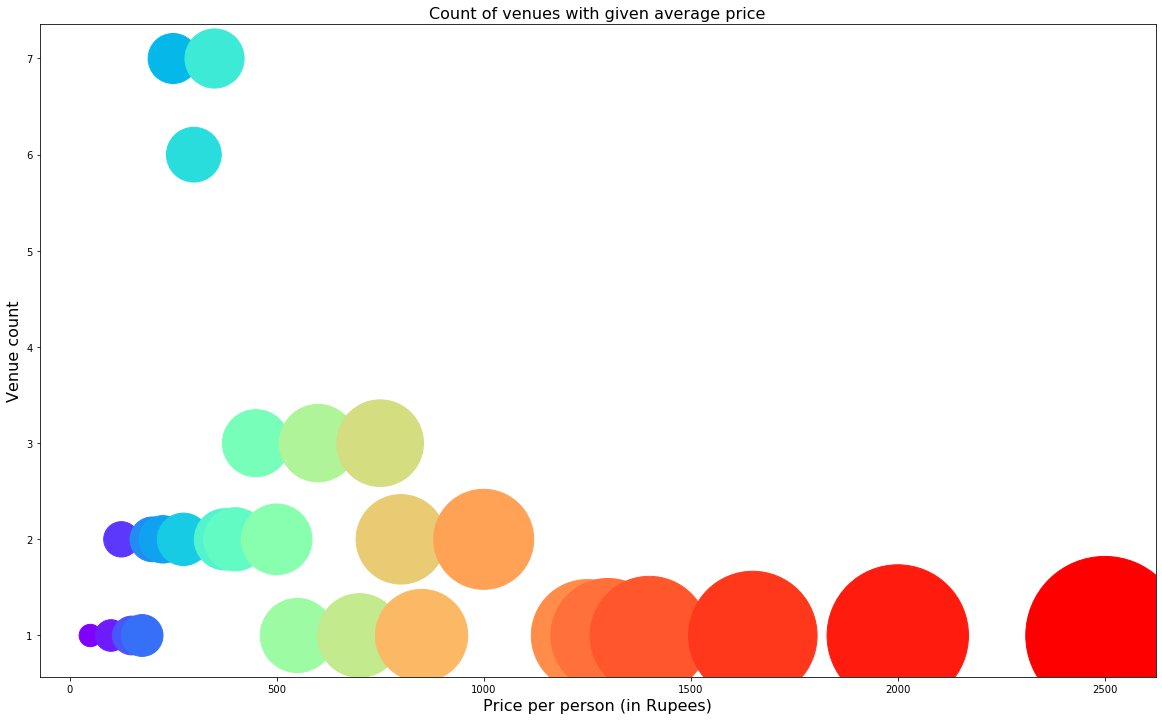

In [33]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person (in Rupees)", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot, we can see a lot of restaurants in the price range of Rs. 0 - Rs. 500<br><br>
Let's create a plot according to the budget as well!

In [34]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(mumbai_map)  

mumbai_map.save("Mumbai Venues Prices.html")
mumbai_map

The map depicts a lot of 'in-budget' restaurants near Chembur East and Ghatkopar.<br><br>
<h3> Clustering</h3><br>
I will now go ahead and begin the Clustering part.

In [35]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0,Good
1,1,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0,Good
2,1,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.4,"Ground Floor, First International Financial Ce...",2500.0,Excellent
3,0,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0,Excellent
4,1,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",1250.0,Excellent


In [36]:
mumbai_map = folium.Map(location = [MUM_LATITUDE, MUM_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(mumbai_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(mumbai_map)

mumbai_map.save("Venues Clusters.html")
mumbai_map

Let's check the venues of the clusters formed

In [37]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Ice Cream Shop,Natural Ice Cream,19.0776,72.8628,1.0,4.1,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",150.0,Excellent
1,0,Indian Restaurant,Delhi Zaika,19.0770,72.8784,2.0,3.8,"5/6, Near Kamran Kalpana Theater, LBS Marg, Ku...",350.0,Good
2,0,Dessert Shop,Theobroma,19.0637,72.8621,2.0,4.2,"The Capital, Ground Floor, Bandra Kurla Comple...",450.0,Excellent
3,0,Coffee Shop,Starbucks Coffee,19.0865,72.8898,2.0,4.1,"First Floor, Phoenix Market City, LBS Marg, Ku...",350.0,Excellent
4,0,Irani Cafe,SodaBottleOpenerWala,19.0638,72.8620,3.0,4.1,"Ground Floor, The Capital Building, G Block, B...",750.0,Excellent
5,0,Indian Restaurant,Naaz Hotel,19.0846,72.8893,2.0,4.1,"Kantharia Mahal, LBS Road, Opposite Phoenix Ma...",350.0,Excellent
6,0,Restaurant,Ivy Restaurant and Banquets,19.0696,72.9004,3.0,4.1,"Above Shopper's Stop, Amar Mahal, Chembur, Mumbai",800.0,Excellent
7,0,Chinese Restaurant,Hotel Darshan,19.0828,72.8851,1.0,3.5,"Opposite Kohinoor City Gate, Kurla West, Near ...",125.0,Good
8,0,Hotel,Love & Latte,19.1022,72.8782,2.0,3.9,"The ORB, Retail Arcade, Unit G2 & G3, Ground F...",450.0,Good
9,0,Indian Restaurant,Sadguru Veg Diet,19.0622,72.9005,2.0,3.8,"Janata Market, Near Chembur Station, Chembur, ...",350.0,Good


In [27]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 2.06 and rating spread around 3.80


In [38]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Tuskers - Sofitel,19.0673,72.8692,4.0,4.0,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",1650.0,Good
1,1,Hotel,O22 - Trident,19.0672,72.8675,4.0,4.0,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",2000.0,Good
2,1,Indian Restaurant,Masala Library,19.0690,72.8696,4.0,4.4,"Ground Floor, First International Financial Ce...",2500.0,Excellent
3,1,Deli / Bodega,Smoke House Deli,19.0688,72.8695,4.0,4.3,"3A, Ground Floor, 1st International Financial ...",1250.0,Excellent
4,1,Dim Sum Restaurant,Yauatcha,19.0611,72.8626,4.0,4.5,"Raheja Towers, Bandra Kurla Complex, Mumbai",1400.0,Excellent
5,1,Brewery,British Brewing Company,19.1077,72.8834,4.0,4.1,"Ground Floor, Times Square Tech Park, Andheri ...",1000.0,Excellent
6,1,Lounge,Wild Orchids,19.0616,72.9016,4.0,3.8,"Hotel Royal Orchid, NG Acharya Marg, Chembur, ...",1000.0,Good
7,1,Pizza Place,Pa Pa Ya,19.0550,72.8506,4.0,4.3,"G-2, Ground Floor, North Avenue, Maker Maxity,...",1300.0,Excellent


In [39]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 4.17


<h3> -> Results and Discussion </h3>
The Foursquare and Zomato APIs were indeed helpful in finding out some really good restaurants in Mumbai. By good, I can clearly say that those restaurants are classified with respect to the budget and the rating received.<br><br>
I got a list of 183 restaurants to research on and I had to keep out some of those because of the inefficiency of the connection of the two APIs and the location variancies. To be precise, 17 of the 183 venues were discarded and the rest were acted upon.<br><br>
From the initial plot, it was evident that the people of Mumbai were attracted to <b>'Indian Restaurants'</b> more than anything else and therefore there were a lot of those present in the area selected for analysis. Someone who has visited the country for a short period would really like to try out Indian food and he/she would be spoiled for choices with the opportunity in Mumbai.<br><br>
Just one disappointment to the visitor will be that a maximum of restaurants in Mumbai are rated close to <b>3.4 out of 5</b> and it is not really impressive. However, it is not degrading either as it is considered to be in the <b>'Good'</b> quality of ratings and the person can have a good time dining out. When I plotted these places, a lot of worthy restaurants were found to be situated at <b>Chembur and Ghatkopar</b>.<br><br>
Talking about the prices of food, I got many restaurants with average price in the range of <b>Rs. 0 to Rs. 500</b>. There was a variation in the price ranges and the maximum was above Rs. 2500. But it can be said that except the range with most restaurants, the other ranges were quite balanced with the number of restaurants. The lower priced restaurants were more towards <b>Chembur East and Ghatkopar</b>

<h3> -> Conclusion </h3>
The area around Chembur and Ghatkopar is perfect for tourists wanting Indian Restaurants finding 'Good' quality food at a reasonable budget and these areas also have a wide variety of venues if someone not of the aforementioned preferabilites visits Mumbai.